# Frequentist Inference Case Study - Part B

## Learning objectives

Welcome to Part B of the Frequentist inference case study! The purpose of this case study is to help you apply the concepts associated with Frequentist inference in Python. In particular, you'll practice writing Python code to apply the following statistical concepts: 
* the _z_-statistic
* the _t_-statistic
* the difference and relationship between the two
* the Central Limit Theorem, including its assumptions and consequences
* how to estimate the population mean and standard deviation from a sample
* the concept of a sampling distribution of a test statistic, particularly for the mean
* how to combine these concepts to calculate a confidence interval

In the previous notebook, we used only data from a known normal distribution. **You'll now tackle real data, rather than simulated data, and answer some relevant real-world business problems using the data.**

## Hospital medical charges

Imagine that a hospital has hired you as their data scientist. An administrator is working on the hospital's business operations plan and needs you to help them answer some business questions. 

In this assignment notebook, you're going to use frequentist statistical inference on a data sample to answer the questions:
* has the hospital's revenue stream fallen below a key threshold?
* are patients with insurance really charged different amounts than those without?

Answering that last question with a frequentist approach makes some assumptions, and requires some knowledge, about the two groups.

We are going to use some data on medical charges obtained from [Kaggle](https://www.kaggle.com/easonlai/sample-insurance-claim-prediction-dataset). 

For the purposes of this exercise, assume the observations are the result of random sampling from our single hospital. Recall that in the previous assignment, we introduced the Central Limit Theorem (CLT), and its consequence that the distributions of sample statistics approach a normal distribution as $n$ increases. The amazing thing about this is that it applies to the sampling distributions of statistics that have been calculated from even highly non-normal distributions of data! Recall, also, that hypothesis testing is very much based on making inferences about such sample statistics. You're going to rely heavily on the CLT to apply frequentist (parametric) tests to answer the questions in this notebook.

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import t, norm, ttest_ind
from numpy.random import seed
medical = pd.read_csv('insurance2.csv')

In [2]:
medical.shape

(1338, 8)

In [4]:
medical.head()

,age,sex,bmi,children,smoker,region,charges,insuranceclaim
0,19,0,27.900,0,1,3,16884.92400,1
1,18,1,33.770,1,0,2,1725.55230,1
2,28,1,33.000,3,0,2,4449.46200,0
3,33,1,22.705,0,0,1,21984.47061,0
4,32,1,28.880,0,0,1,3866.85520,1


__Q1:__ Plot the histogram of charges and calculate the mean and standard deviation. Comment on the appropriateness of these statistics for the data.

__A:__

In [5]:
# From our random sample of medical charges
charges_xbar = medical.charges.mean() # sample mean
charges_s = medical.charges.std() # sample standard deviation
print('mean = ' + str(charges_xbar))
print('standard deviation = ' + str(charges_s))

mean = 13270.422265141257
standard deviation = 12110.011236693994


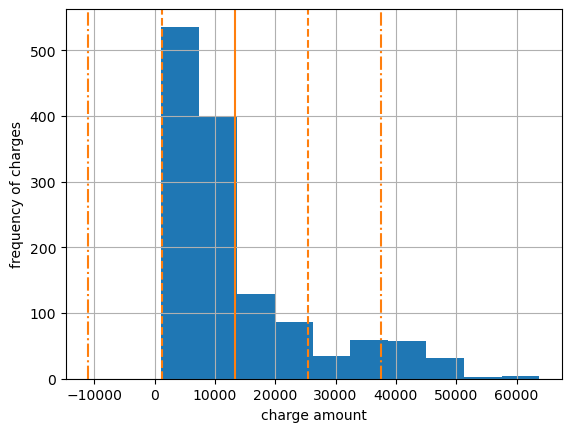

In [6]:
_ = medical.charges.hist()
_ = plt.xlabel('charge amount')
_ = plt.ylabel('frequency of charges')
_ = plt.axvline(charges_xbar, color='C1')
_ = plt.axvline(charges_xbar - charges_s, color='C1', linestyle='--')
_ = plt.axvline(charges_xbar + charges_s, color='C1', linestyle='--')
_ = plt.axvline(charges_xbar - charges_s*2, color='C1', linestyle='-.')
_ = plt.axvline(charges_xbar + charges_s*2, color='C1', linestyle='-.')

The plot above shows the histogram of the medical charges, the sample mean, and up to two standard deviations from the mean. The sample distribution is not a normal distribution, but rather an exponential distribution.

__Q2:__ The administrator is concerned that the actual average charge has fallen below 12,000, threatening the hospital's operational model. On the assumption that these data represent a random sample of charges, how would you justify that these data allow you to answer that question? And what would be the most appropriate frequentist test, of the ones discussed so far, to apply?

__A:__ I recommend looking at the confidence interval of the mean of the sampling distribution of the sample means, created from bootstrapping the original population sample of medical charges.

__Q3:__ Given the nature of the administrator's concern, what is the appropriate confidence interval in this case? A ***one-sided*** or ***two-sided*** interval? (Refresh your understanding of this concept on p. 399 of the *AoS*). Calculate the critical value and the relevant 95% confidence interval for the mean, and comment on whether the administrator should be concerned.

__A:__ The appropriate confidence interval in this case is one-sided since the concern is only about the mean charge falling below 12,000.

In [26]:
# function to take random samples from our population with replacement
def get_sample_charges(n):
    return np.random.choice(medical.charges, n)

In [30]:
bootstrapped_sample_means = []
for i in range(1000):
    bootstrapped_sample_means.append(get_sample_charges(len(medical.charges)).mean())

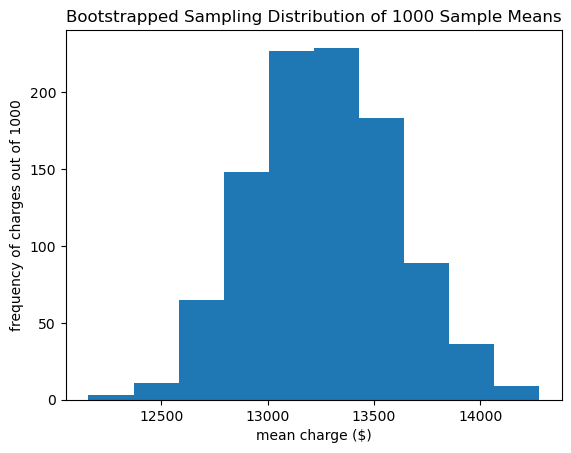

In [31]:
# plot the sampling distribution
_ = plt.hist(bootstrapped_sample_means)
_ = plt.xlabel('mean charge ($)')
_ = plt.ylabel('frequency of charges out of 1000')
_ = plt.title('Bootstrapped Sampling Distribution of 1000 Sample Means')

The above is the bootstrapped sampling distribution of the means of 1000 samples the size of our original sample taken from the unknown population of medical charges. The Central Limit Theorem tells us the expected mean of this distribution will be equal to the population mean, and standard deviation of the sampling distribution will be $\sigma / \sqrt n$.

In [41]:
# sampling distribution mean ~= population mean
sample_dist_mean = np.mean(bootstrapped_sample_means)
print('sampling distribution mean = ' + str(sample_dist_mean))

# sampling distribution std
sample_dist_std = np.std(bootstrapped_sample_means)
print('sampling distribution std = ' + str(sample_dist_std))

# From CLT: population standard deviation ~= sampling distribution standard deviation / sqrt(fixed sample size)
approx_pop_std = sample_dist_std * np.sqrt(len(medical.charges))
print('approx. population std = ' + str(approx_pop_std))

sampling distribution mean = 13269.017880341522
sampling distribution std = 333.3902572531692
approx. population std = 12194.976307427798


In [56]:
# Mean Charge Margin of Error (M.O.E.) for 95% confidence (one-tailed)
margin_of_error = norm.ppf(0.05) * sample_dist_std
print('M.O.E. = ' + str(margin_of_error))

# 95% confidence interval
confidence_interval_95 = sample_dist_mean + margin_of_error, np.inf
print('The one-sided 95% confidence interval for the mean medical charge is ' + str(confidence_interval_95))

M.O.E. = -548.37817383316
The one-sided 95% confidence interval for the mean medical charge is (12720.639706508362, inf)


Given the results from our boostrapped sampling distribution statistics, we are confident that 95% of the time, the mean medical charge will be greater than or equal to 12,720.00. Therefore, the administator does not need to worry that the mean medical charge has fallen beneath the 12,000.00 threshold.

The administrator then wants to know whether people with insurance really are charged a different amount to those without.

__Q4:__ State the null and alternative hypothesis here. Use the _t_-test for the difference between means, where the pooled standard deviation of the two groups is given by:
\begin{equation}
s_p = \sqrt{\frac{(n_0 - 1)s^2_0 + (n_1 - 1)s^2_1}{n_0 + n_1 - 2}}
\end{equation}

and the *t*-test statistic is then given by:

\begin{equation}
t = \frac{\bar{x}_0 - \bar{x}_1}{s_p \sqrt{1/n_0 + 1/n_1}}.
\end{equation}

(If you need some reminding of the general definition of ***t-statistic***, check out the definition on p. 404 of *AoS*). 

What assumption about the variances of the two groups are we making here?

__A:__

The null hypothesis (H0) is that the true difference between these group means is zero.

The alternate hypothesis (Ha) is that the true difference is different from zero.

*We are assuming the population standard deviation between the with and without insurance groups are the same.

__Q5:__ Perform this hypothesis test both manually, using the above formulae, and then using the appropriate function from [scipy.stats](https://docs.scipy.org/doc/scipy/reference/stats.html#statistical-tests) (hint, you're looking for a function to perform a _t_-test on two independent samples). For the manual approach, calculate the value of the test statistic and then its probability (the p-value). Verify you get the same results from both.

__A:__ 

In [38]:
### By hand (i.e. using formulas above)
# By using the t-test, we are assuming the data of our two groups
#    are independent,
#    are (approximately) normally distributed, and
#    have a similar amount of variance within each group being compared (a.k.a. homogeneity of variance)
#
# Note:
#    2-sample t-test (a.k.a. independent t-test)
#    2-tailed t-test (only care if the groups are different from one another)

# Group samples
sample_with_insurance = medical.charges[medical.insuranceclaim == 1] # aliased as swi
sample_without_insurance = medical.charges[medical.insuranceclaim == 0] # aliased as swoi

# Sample statistics
swi_mean = sample_with_insurance.mean()
swi_std = sample_with_insurance.std()
swi_n = len(sample_with_insurance)

swoi_mean = sample_without_insurance.mean()
swoi_std = sample_without_insurance.std()
swoi_n = len(sample_without_insurance)

print('Sample Statistic: With Insurance | Without Insurance')
print('xbar = ' + str(swi_mean) + ' | ' + str(swoi_mean))
print('s = ' + str(swi_std) + ' | ' + str(swoi_std))
print('n = ' + str(swi_n) + ' | ' + str(swoi_n))

# Pooled standard deviation
s_pooled = np.sqrt( ((swi_n - 1)*swi_std**2 + (swoi_n - 1)*swoi_std**2) / (swi_n + swoi_n - 2) )
print('pooled std = ' + str(s_pooled))

# t-test statistic
t_stat = (swi_mean - swoi_mean) / (s_pooled * np.sqrt(1/swi_n + 1/swoi_n))
print('t-test statistic = ' + str(t_stat))

# Degrees of freedom
df = swi_n + swoi_n - 2
print('DOF = ' + str(df))

# p-value
p_value = 1 - t.cdf(t_stat, df)
print('p-value = ' + str(p_value))

Sample Statistic: With Insurance | Without Insurance
xbar = 16423.928276537663 | 8821.421892306294
s = 14045.928418802127 | 6446.510126811736
n = 783 | 555
pooled std = 11520.034268775256
t-test statistic = 11.89329903087671
DOF = 1336
p-value = 0.0


In [40]:
### Using scipy.stats
statistic, pvalue = ttest_ind(
    sample_with_insurance,
    sample_without_insurance,
    axis=0,
)
print('From scipy.stats: t-test statistic = ' + str(statistic))
print('From scipy.stats: p-value = ' + str(pvalue))

From scipy.stats: t-test statistic = 11.893299030876712
From scipy.stats: p-value = 4.461230231620717e-31


Congratulations! Hopefully you got the exact same numerical results. This shows that you correctly calculated the numbers by hand. Secondly, you used the correct function and saw that it's much easier to use. All you need to do is pass your data to it.

__Q6:__ Conceptual question: look through the documentation for statistical test functions in scipy.stats. You'll see the above _t_-test for a sample, but can you see an equivalent one for performing a *z*-test from a sample? Comment on your answer.

__A:__ I cannot find an equivalent function in scipy.stats for performing a z-test from a sample as the ttest_ind does for t-tests. However, the scipy.stats documentation suggests that there are topics that are out of scope for SciPy and are covered by other packages, such as statsmodels. Statsmodels does contain a ztest function that is equivalent to scipy.stats' ttest_ind function.

## Learning outcomes

Having completed this project notebook, you now have good hands-on experience:
* using the central limit theorem to help you apply frequentist techniques to answer questions that pertain to very non-normally distributed data from the real world
* performing inference using such data to answer business questions
* forming a hypothesis and framing the null and alternative hypotheses
* testing this using a _t_-test